In [1]:
import sys, os
sys.path.append("../")

import pandas as pd
import yaml
import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict
from flax.training import train_state, checkpoints
from ml_collections.config_dict import ConfigDict
import numpy as vnp
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm, sigma2, generate
from models.train_utils import create_input_iter, param_count, StateStore, train_step
from datasets import load_data

EPS = 1e-7

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = "/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/"
logging_dir = "/n/holystore01/LABS/iaifi_lab/Users/smsharma/set-diffuser/logging/"
# run_name = "heartfelt-tulip-23"  # wandb run name
# run_name = "dry-tree-37"  # wandb run name
run_name = "earthy-water-40"  # wandb run name

In [3]:
n_particles = 5000
n_features = 3

# Load and normalize
x = np.load("{}/halos.npy".format(data_dir))

x = x.at[:, :, -1].set(np.log10(x[:, :, -1]))

x_mean = x.mean(axis=(0,1))
x_std = x.std(axis=(0,1))
x = (x - x_mean + 1e-7) / (x_std + 1e-7)

x = x[:, :n_particles, :n_features]
conditioning = np.array(pd.read_csv("{}/cosmology.csv".format(data_dir)).values)
conditioning = conditioning[:, [0, -1]]  # Select only omega_m and sigma_8

mask = np.ones((x.shape[0], n_particles))


In [4]:
config_file = "../logging/cosmology/{}/config.yaml".format(run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)


In [5]:
print("{} devices visible".format(jax.device_count()))

# Load the dataset
train_ds, _ = load_data(config.data.dataset, config.data.n_features, config.data.n_particles, 4, config.seed, **config.data.kwargs)
batches = create_input_iter(train_ds)

# Score and (optional) encoder model configs
score_dict = FrozenDict(config.score)
encoder_dict = FrozenDict(config.encoder)
decoder_dict = FrozenDict(config.decoder)

# Diffusion model
vdm = VariationalDiffusionModel(d_feature=config.data.n_features, timesteps=config.vdm.timesteps, noise_schedule=config.vdm.noise_schedule, noise_scale=config.vdm.noise_scale, gamma_min=config.vdm.gamma_min, gamma_max=config.vdm.gamma_max, score=config.score.score, score_dict=score_dict, embed_context=config.vdm.embed_context, d_context_embedding=config.vdm.d_context_embedding, n_classes=config.vdm.n_classes, use_encdec=config.vdm.use_encdec, encoder_dict=encoder_dict, decoder_dict=decoder_dict)

# Pass a test batch through to initialize model
x_batch, conditioning_batch, mask_batch = next(batches)
rng = jax.random.PRNGKey(42)
_, params = vdm.init_with_output({"sample": rng, "params": rng}, x_batch[0], conditioning_batch[0], mask_batch[0])

print(f"Params: {param_count(params):,}")

# Training config and state
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=config.optim.learning_rate, warmup_steps=config.training.warmup_steps, decay_steps=config.training.n_train_steps)
tx = optax.adamw(learning_rate=schedule, weight_decay=config.optim.weight_decay)
state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=tx)


1 devices visible
Params: 2,179,043


In [6]:
ckpt_dir = "{}/cosmology/{}/".format(logging_dir, run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")


In [7]:
n_samples = 8
idx_rnd = vnp.random.choice(vnp.arange(len(x)), size=n_samples, replace=False)

cond_gen = conditioning[idx_rnd]
mask_gen = mask[idx_rnd]

rng, _ = jax.random.split(rng)

x_samples = generate(vdm, restored_state.params, rng, (n_samples, config.data.n_particles), conditioning=cond_gen, mask=mask_gen, steps=500)
x_samples = x_samples.mean()


In [9]:
idx = 0
x_rnd = jax.random.uniform(rng, shape=x[idx_rnd[idx], :config.data.n_particles, :3].shape, minval=0, maxval=1000)

In [10]:
sys.path.append("../../ili-summarizer/")
sys.path.append("../../ili-summarizer/summarizer/")

from knn.knn import KNN
from data.catalogue import Catalogue


In [11]:
r_bins = np.linspace(0, 100, 100)
k = np.arange(1, 10)
knn = KNN(r_bins, k)


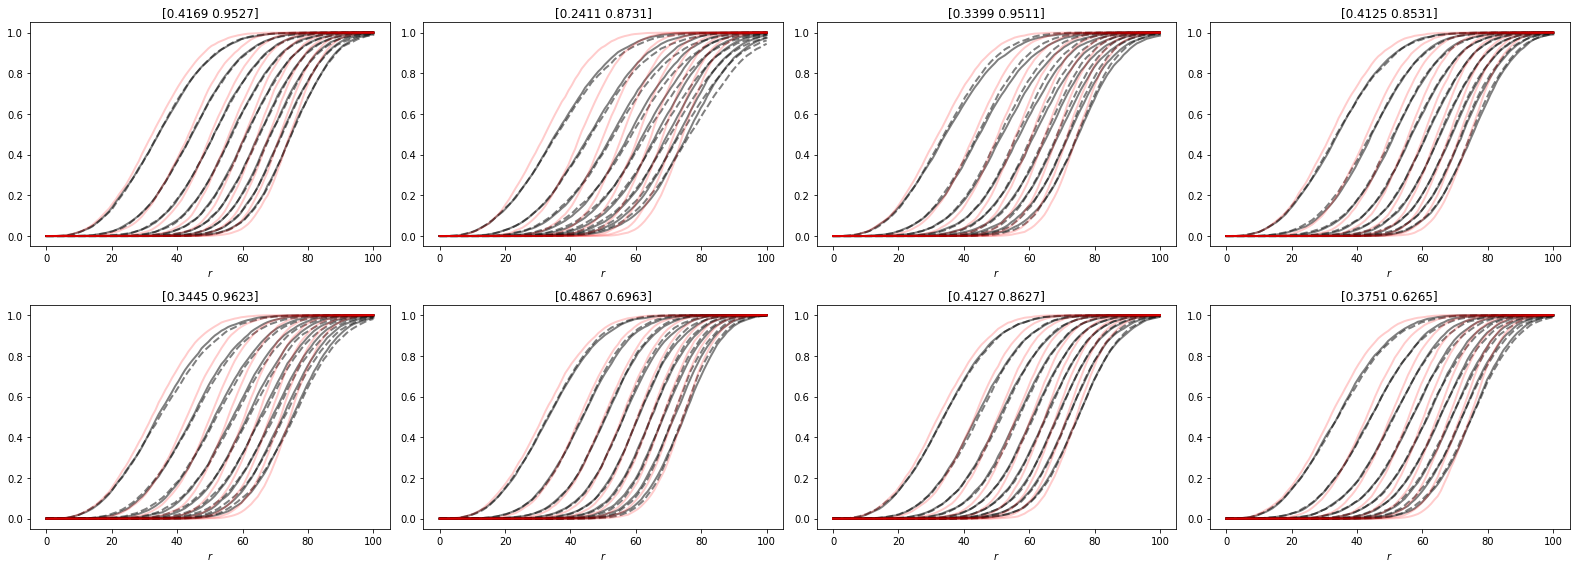

In [12]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(22, 8))
gs = GridSpec(2, 4)

for idx in range(8):
    
    ax = fig.add_subplot(gs[idx])
    
    cat = Catalogue(pos=x[idx_rnd[idx], :config.data.n_particles, :3] * x_std[:3] + x_mean[:3], vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
    knn_res = knn(cat)

    for i in range(len(knn_res)):
        plt.plot(r_bins, knn_res[i], color='k', ls='--', alpha=0.5, lw=2, label="Sim" if i == 0 else None)

    cat = Catalogue(pos=x_samples[idx, :, :3] * x_std[:3] + x_mean[:3], vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
    knn_res = knn(cat)

    for i in range(len(knn_res)):
        plt.plot(r_bins, knn_res[i], color='k', ls='-', alpha=0.5, lw=2, label="Gen" if i == 0 else None)

    cat = Catalogue(pos=x_rnd, vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
    knn_res = knn(cat)

    for i in range(len(knn_res)):
        plt.plot(r_bins, knn_res[i], color='red', ls='-', alpha=0.2, lw=2, label="Rnd" if i == 0 else None)

    ax.set_xlabel("$r$")

    ax.set_title(conditioning[idx_rnd[idx]])

plt.tight_layout()


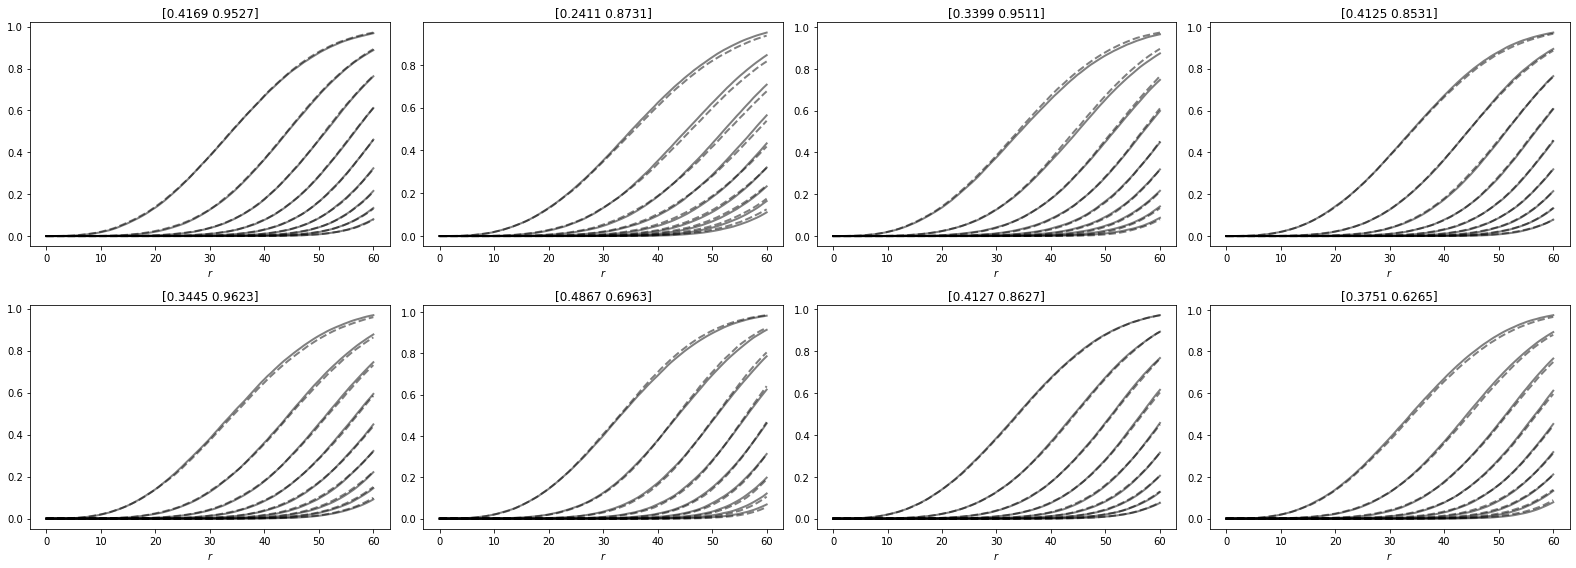

In [20]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from cosmo_utils.knn import get_CDFkNN


r_bins = np.linspace(0, 60., 100)
k = np.arange(1, 10)
boxsize = 1000.
key = jax.random.PRNGKey(0)
random_points = boxsize * jax.random.uniform(
    key,
    shape=(x_samples.shape[1] * 10, 3),
)
fig = plt.figure(figsize=(22, 8))
gs = GridSpec(2, 4)
for idx in range(8):
    ax = fig.add_subplot(gs[idx])
    pos = x[idx_rnd[idx], :config.data.n_particles, :3] * x_std[:3] + x_mean[:3]
    key = jax.random.PRNGKey(0)
    random_points = boxsize * jax.random.uniform(
        key,
        shape=(x_samples.shape[1] * 10, 3),
    )
    knn_true = get_CDFkNN(
        r_bins=r_bins,
        pos=pos,
        random_pos=random_points,
        boxsize=boxsize,
        k=k,
    )
    for i in range(len(knn_true)):
        plt.plot(r_bins, knn_true[i], color="k", ls="--", alpha=0.5, lw=2, label="Sim" if i == 0 else None)
    pos = x_samples[idx, :, :3] * x_std[:3] + x_mean[:3]
    pos = pos % boxsize
    key = jax.random.PRNGKey(0)
    random_points = boxsize * jax.random.uniform(
        key,
        shape=(x_samples.shape[1] * 10, 3),
    )
    knn_res = get_CDFkNN(
        r_bins=r_bins,
        pos=pos,
        random_pos=random_points,
        boxsize=boxsize,
        k=k,
    )
    for i in range(len(knn_res)):
        plt.plot(r_bins, knn_res[i], color="k", ls="-", alpha=0.5, lw=2, label="Gen" if i == 0 else None)
    ax.set_xlabel("$r$")
    ax.set_title(conditioning[idx_rnd[idx]])
plt.tight_layout()

In [21]:
omega_m = 0.2  # Set parameters
sigma_8 = 0.7

cosmology = np.mean(conditioning, axis=0)

cosmology = cosmology.at[0].set(omega_m)
cosmology = cosmology.at[-1].set(sigma_8)

In [22]:
cosmology

Array([0.2, 0.7], dtype=float32)

In [25]:
n_samples = 10  # How many samples from same cosmology

rng = jax.random.PRNGKey(33)
x_samples_cosmo = generate(vdm, restored_state.params, rng, (n_samples, config.data.n_particles), conditioning=np.repeat(np.array([cosmology]), n_samples, 0), mask=np.ones((n_samples, config.data.n_particles)), steps=100)
x_samples_cosmo = x_samples_cosmo.mean()

In [26]:
x_samples_cosmo

Array([[[-1.2676316 ,  0.15478091,  0.59857345],
        [-1.4716816 ,  0.5731816 ,  0.4892982 ],
        [ 0.57759285,  0.06536629,  0.88366246],
        ...,
        [-0.42903748, -0.7442587 ,  0.2999701 ],
        [ 0.7763355 ,  1.1635629 ,  1.3702312 ],
        [ 0.24130821, -1.5908941 , -1.0167747 ]],

       [[ 1.4697608 , -0.97610974,  0.69710344],
        [-0.7598278 , -0.30668962,  1.234902  ],
        [ 0.7873326 , -1.1730552 ,  0.02122207],
        ...,
        [-0.31520382, -0.16400042, -0.02115906],
        [-0.2862047 ,  1.1872354 ,  0.6664862 ],
        [ 0.42556432,  1.1919007 , -0.24541128]],

       [[ 0.81184953, -1.6444223 ,  0.81603587],
        [ 0.43063334, -0.6900791 , -0.18207519],
        [ 1.4163758 ,  0.10259336, -0.50309145],
        ...,
        [ 1.5344933 , -1.670881  ,  1.7134237 ],
        [-0.39403608, -1.2258842 ,  1.606509  ],
        [-0.9068022 , -0.7952326 ,  1.709251  ]],

       ...,

       [[ 0.24846809, -0.87153447, -1.1414038 ],
        [-0

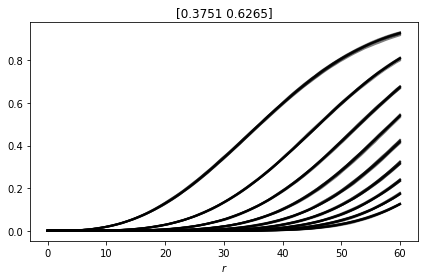

In [29]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from cosmo_utils.knn import get_CDFkNN


r_bins = np.linspace(0, 60., 100)
k = np.arange(1, 10)
boxsize = 1000.
key = jax.random.PRNGKey(0)
random_points = boxsize * jax.random.uniform(
    key,
    shape=(x_samples_cosmo.shape[1] * 10, 3),
)
# fig = plt.figure(figsize=(22, 8))
# gs = GridSpec(2, 4)

fig, ax = plt.subplots()

for idx in range(8):
    # ax = fig.add_subplot(gs[idx])
    pos = x[idx_rnd[idx], :config.data.n_particles, :3] * x_std[:3] + x_mean[:3]
    key = jax.random.PRNGKey(0)
    random_points = boxsize * jax.random.uniform(
        key,
        shape=(x_samples_cosmo.shape[1] * 10, 3),
    )
    # knn_true = get_CDFkNN(
    #     r_bins=r_bins,
    #     pos=pos,
    #     random_pos=random_points,
    #     boxsize=boxsize,
    #     k=k,
    # )
    # for i in range(len(knn_true)):
    #     plt.plot(r_bins, knn_true[i], color="k", ls="--", alpha=0.5, lw=2, label="Sim" if i == 0 else None)
        
    pos = x_samples_cosmo[idx, :, :3] * x_std[:3] + x_mean[:3]
    pos = pos % boxsize
    key = jax.random.PRNGKey(0)
    random_points = boxsize * jax.random.uniform(
        key,
        shape=(x_samples_cosmo.shape[1] * 10, 3),
    )
    knn_res = get_CDFkNN(
        r_bins=r_bins,
        pos=pos,
        random_pos=random_points,
        boxsize=boxsize,
        k=k,
    )
    for i in range(len(knn_res)):
        plt.plot(r_bins, knn_res[i], color="k", ls="-", alpha=0.5, lw=2, label="Gen" if i == 0 else None)
    ax.set_xlabel("$r$")
    ax.set_title(conditioning[idx_rnd[idx]])
plt.tight_layout()

In [31]:
from pycorr import TwoPointCorrelationFunction

def compute_2pcf(
    sample: np.array,
    boxsize: float,
    r_bins: np.array,
) -> np.array:
    """Get the monopole of the two point correlation function

    Args:
        sample (np.array): positions
        boxsize (float): size of the box
        r_bins (np.array): bins in pair separation

    Returns:
        np.array: monopole of the two point correlation function
    """
    mu_bins = np.linspace(-1, 1, 201)
    return TwoPointCorrelationFunction(
        "smu",
        edges=(onp.array(r_bins), onp.array(mu_bins)),
        data_positions1=onp.array(sample).T,
        engine="corrfunc",
        n_threads=2,
        boxsize=boxsize,
        los="z",
    )(ells=[0])[0]

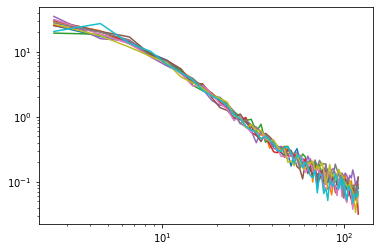

In [38]:
import numpy as onp

r_bins = np.linspace(0.5, 120.0, 60)

for idx in range(10):
    x_samples_cosmo[idx, :, :3] * x_std[:3] + x_mean[:3]
    tpcf = compute_2pcf(x_samples_cosmo[idx, :, :3] * x_std[:3] + x_mean[:3], boxsize, r_bins)

    plt.plot(r_bins[1:], tpcf)
    
plt.xscale("log")
plt.yscale("log")